## Machine learning modeling - Iteration #4


In [124]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil
import jenkspy
import statsmodels
import statsmodels.api as sm

# ml modules
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [224]:
# read in 990 data that has been
# with features already adjusted in 2nd iteration
df = pd.read_csv('data/990_model_data_3.csv')

In [225]:
df.shape

(26881, 28)

In [226]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792.0,11,11,37,0.0,0.0,0.0,0.0,39372255.0,26541056.0,12831199.0,0.0,39367859.0,26785093.0,12582766.0,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036.0,9,8,81,8.0,52565.0,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299.0,188534687.0,170915216.0,17619471.0,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978.0,21,19,53,200.0,16110.0,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972.0,3640881.0,852359.0,2788522.0,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298.0,8,7,442,15.0,0.0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630.0,56726534.0,12198910.0,44527624.0,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176.0,12,12,139,50.0,2437.0,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724.0,10535130.0,3089889.0,7445241.0,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


## 4th Feature Iteration - bin categories that are contributing the most information into sub-groups 

### gross_receipts

In [227]:
# create breaks in contractor_100K_count
gr_breaks = jenkspy.jenks_breaks(df.gross_receipts, nb_class=10)

In [228]:
df['gr_breaks'] = pd.cut(df.gross_receipts,
                        bins=gr_breaks,
                        include_lowest=True)

In [229]:
# examin count in each category
df.gr_breaks.value_counts()

(-0.001, 25507108.0]            17944
(25507108.0, 71194601.0]         4588
(71194601.0, 140849833.0]        1778
(140849833.0, 234449446.0]        896
(234449446.0, 351172329.0]        500
(1147856790.0, 1309779237.2]      344
(351172329.0, 491279446.0]        340
(491279446.0, 665633697.0]        225
(665633697.0, 890053921.0]        158
(890053921.0, 1147856790.0]       108
Name: gr_breaks, dtype: int64

### asset_tot_beginyr

In [230]:
# create breaks in contractor_100K_count
asset_breaks = jenkspy.jenks_breaks(df.asset_tot_beginyr, nb_class=10)

In [231]:
df['asset_breaks'] = pd.cut(df.asset_tot_beginyr,
                        bins=asset_breaks,
                        include_lowest=True)

In [232]:
# examin count in each category
df.asset_breaks.value_counts()

(-4111260.001, 35088404.0]      18195
(35088404.0, 102886557.0]        4166
(102886557.0, 208054156.0]       1831
(208054156.0, 350738384.0]        911
(350738384.0, 535720116.0]        570
(535720116.0, 768367257.0]        361
(1744198284.0, 2007782441.8]      315
(768367257.0, 1041006841.0]       245
(1041006841.0, 1361460585.0]      173
(1361460585.0, 1744198284.0]      114
Name: asset_breaks, dtype: int64

### liability_tot_beginyr

In [233]:
# create breaks in contractor_100K_count
liab_breaks = jenkspy.jenks_breaks(df.liability_tot_beginyr, nb_class=10)

In [234]:
df['liab_breaks'] = pd.cut(df.liability_tot_beginyr,
                        bins=liab_breaks,
                        include_lowest=True)

In [235]:
# examin count in each category
df.liab_breaks.value_counts()

(-3809356.001, 15272310.0]     19268
(15272310.0, 47771545.0]        3635
(47771545.0, 95940371.0]        1468
(95940371.0, 162294709.0]        831
(162294709.0, 254319823.0]       543
(938503231.0, 1082904612.0]      322
(254319823.0, 366907253.0]       307
(366907253.0, 512690813.0]       234
(512690813.0, 704836893.0]       147
(704836893.0, 938503231.0]       126
Name: liab_breaks, dtype: int64

In [236]:
df_dummies.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299,188534687,170915216,17619471,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978,21,19,53,200.0,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298,8,7,442,15.0,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176,12,12,139,50.0,2437,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


In [237]:
# create features for classification
# while removing those I created in designing
# my target variable
X = pd.get_dummies(df_dummies).drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df_dummies.TARGET_FEATURE

In [238]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forrest Classifier 


In [239]:
# create model, check for overfitting
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=8)

cross_val_score(rfc, X, y, cv=5)

array([0.8951088 , 0.89269109, 0.8937872 , 0.89490327, 0.89786047])

In [240]:
rfc.fit(X_train, y_train)

predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0016741071428571428
Percent Type II errors: 0.09384300595238096

Test set accuracy:
Percent Type I errors: 0.004649432769202157
Percent Type II errors: 0.09336061000557933


In [241]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19108,36
Actual: Yes,2018,342


In [242]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4803,25
Actual: Yes,502,47


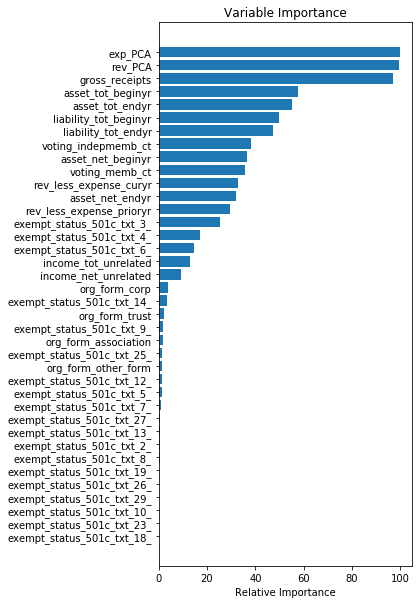

In [243]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');


### KNN Classifier

In [244]:
# fit model based on optimized parameters
knn_clf = KNeighborsClassifier(leaf_size= 1, n_neighbors= 110)

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [245]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [246]:
predict_train = knn_clf.predict(X_train)
predict_test = knn_clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.002464657738095238
Percent Type II errors: 0.10546875

Test set accuracy:
Percent Type I errors: 0.0022317277292170355
Percent Type II errors: 0.09838199739631764


In [247]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19091,53
Actual: Yes,2268,92


In [248]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4816,12
Actual: Yes,529,20


### Gradient Boost Classifier

In [249]:
# Initialize and fit the model.
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
cross_val_score(clf, X, y, cv=5)

array([0.893435  , 0.89138925, 0.88616071, 0.89453125, 0.89376744])

In [250]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.003720238095238095
Percent Type II errors: 0.08361235119047619

Test set accuracy:
Percent Type I errors: 0.015436116793751162
Percent Type II errors: 0.0855495629533197


In [251]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19064,80
Actual: Yes,1798,562


In [252]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4745,83
Actual: Yes,460,89


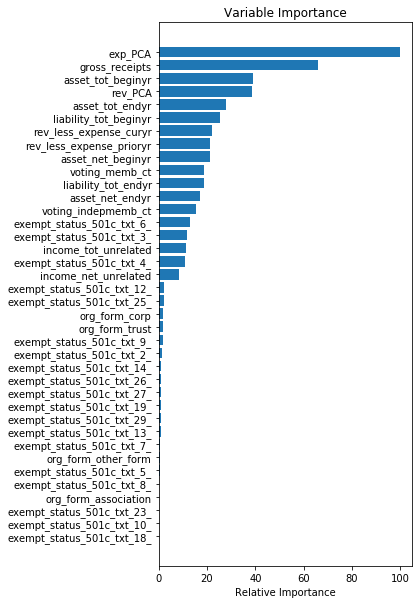

In [253]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

Segmenting gross receipts & count of contractors into categories was not helpful at contributing information that helped my model perform more accurately.

In [254]:
# find 10 most significant features
clf_features = pd.DataFrame(clf.feature_importances_,
            X.columns, columns=['importance']).sort_values(by='importance', ascending=False)

list(clf_features.head(10).index)

['exp_PCA',
 'gross_receipts',
 'asset_tot_beginyr',
 'rev_PCA',
 'asset_tot_endyr',
 'liability_tot_beginyr',
 'rev_less_expense_curyr',
 'rev_less_expense_prioryr',
 'asset_net_beginyr',
 'voting_memb_ct']

### SVC

In [255]:
svc = SVC(gamma='scale', C= 1, class_weight=  'balanced', verbose=True)

svc.fit(X_train, y_train)

[LibSVM]

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [256]:
predict_train = svc.predict(X_train)
predict_test = svc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.016648065476190476
Percent Type II errors: 0.10105096726190477

Test set accuracy:
Percent Type I errors: 0.01710991259066394
Percent Type II errors: 0.09429049655941975


In [257]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,18786,358
Actual: Yes,2173,187


In [258]:
# testing results

pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4736,92
Actual: Yes,507,42


### Export data for further feature iteration

In [259]:
df_dummies.to_csv('data/990_model_data_5.csv', index=None, header=True)